# Theory code example

## Import CAMB


### CAMB

:CAMB: Code for Anisotropies in the Microwave Background
:Author: Antony Lewis and Anthony Challinor
:Homepage: https://camb.info/


### Description and installation


CAMB is a cosmology code for calculating cosmological observables, including
CMB, lensing, source count and 21cm angular power spectra, matter power spectra, transfer functions
and background evolution. The code is in Python, with numerical code implemented in fast modern Fortran.

See the `CAMB python example notebook <https://camb.readthedocs.org/en/latest/CAMBdemo.html>`_ for a
quick introduction to how to use the CAMB Python package.

For a standard non-editable installation use::

    pip install camb [--user]

The --user is optional and only required if you don't have write permission to your main python installation.
To install from source, clone from github using::

    git clone --recursive https://github.com/cmbant/CAMB

Then in the project source root directory use::

    python setup.py install [--user]

If you want to work on the code, you can also just install in place without copying anything using::

    pip install -e . [--user]

You will need gfortran 6 or higher installed to compile. Binary files for Windows are also provided, so these are used instead if no
gfortran installation is found on Windows machines. If you have gfortran installed, "python setup.py make"
(and other standard setup commands) will build the Fortran library on all systems (including Windows without directly using a Makefile).

The python wrapper provides a module called "camb" documented in the `Python CAMB documentation <https://camb.readthedocs.io/en/latest/>`_.

After installation you can also run CAMB from the command line reading parameters from a .ini file, e.g.::

  camb inifiles/planck_2018.ini

To compile the Fortran command-line code run "make camb" in the fortran directory. For full details
see the  `ReadMe <https://camb.info/readme.html>`_.

In [1]:
import os
import sys
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

import scipy
from scipy import integrate
from scipy import constants

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.0.5 installed at /local/home/scasas/anaconda2/envs/py37/lib/python3.7/site-packages/camb-1.0.5-py3.7.egg/camb


# Define the cosmological input parameters

## Fundamental parameters (IST:F)

In [2]:
c_light = scipy.constants.c / 1000 ## in km/s
c_light

299792.458

In [3]:
hubble=0.67
omegab=0.05
omegam=0.32
A_s=2.12605e-9
n_s = 0.96
gamma=0.55
m_nu=0.06 #eV, default CAMB -> 1 massive neutrino, N_eff=3.046, degenerate, nnu=3.046, TCMB=2.7255
w_0 = -1 #LCDM
w_a = 0 #LCDM

## Output, numerical and method parameters

In [99]:
## wanted redshifts
z_list = [0., 0.5, 1.0]
## maximum k in Pk
k_max = 3.0
## nonlinear Pk fitting formula version:
halofit_formula = 'takahashi'

## Derived parameters

In [100]:
omegac=omegam-omegab
omegach2 = omegac*hubble**2
omegabh2 = omegab*hubble**2
H_0 = 100*hubble

In [101]:
pars = camb.CAMBparams()

### Background parameters

In [102]:
pars.set_cosmology(H0=H_0, ombh2=omegabh2, omch2=omegach2, mnu=m_nu)
pars.set_dark_energy(w=w_0, wa=w_a);

### Power spectra parameters

In [103]:
pars.InitPower.set_params(As=A_s, ns=n_s) ;
pars.set_matter_power(redshifts=z_list, kmax=k_max);

Note: redshifts have been re-sorted (earliest first)


## CAMB results

In [104]:
results = camb.get_results(pars)

In [105]:
s8_of_z = np.array(results.get_sigma8())
s8_of_z

array([0.49537748, 0.62809512, 0.8182003 ])

### Use nonlinear power spectra

In [106]:
pars.NonLinear = camb.model.NonLinear_both   # use NonLinear_none for linear

In [107]:
pars.NonLinearModel.set_params(halofit_version=halofit_formula)

## Get Power spectra

In [108]:
results.calc_power_spectra(pars)

In [109]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=k_max, npoints = 500)

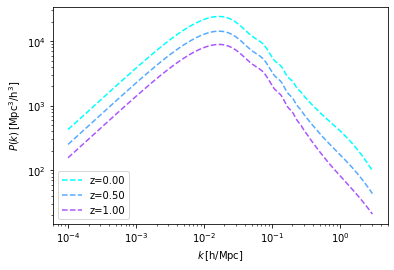

In [110]:
color_list = cm.cool( np.linspace(0.,1.0, len(z)+1 ) )
color_iter=iter(color_list)
for pkk, zz in zip(pk,z):
    c = next(color_iter)
    plt.loglog(kh, pkk, color=c, ls = '--', label='z='+'{:.2f}'.format(zz))
    
plt.xlabel("$k \, \mathrm{[h/Mpc]}$")
plt.ylabel("$P(k) \, \mathrm{[Mpc^3/h^3]}$")
plt.legend(loc='lower left');
#plt.title('Matter power at z=%s and z= %s'%tuple(z));

In [111]:
PK = camb.get_matter_power_interpolator(pars, hubble_units=True, k_hunit=True, log_interp=False)

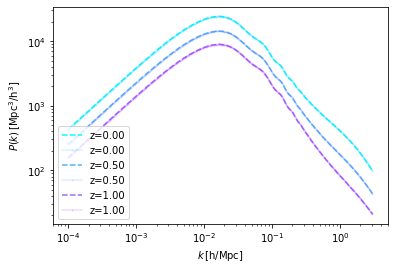

In [120]:
color_list = cm.cool( np.linspace(0.,1.0, 2*(len(z)+1) ) )
color_iter=iter(color_list)
for pkk, zz in zip(pk,z):
    c = next(color_iter)
    plt.loglog(kh, pkk, color=c, ls = '--', label='z='+'{:.2f}'.format(zz))
    c = next(color_iter)
    plt.loglog(kh, PK.P(zz, kh), 'o', color=c, ls = '-', label='z='+'{:.2f}'.format(zz), ms=0.8, alpha=0.2)
    
    
plt.xlabel("$k \, \mathrm{[h/Mpc]}$")
plt.ylabel("$P(k) \, \mathrm{[Mpc^3/h^3]}$")
plt.legend(loc='lower left');
#plt.title('Matter power at z=%s and z= %s'%tuple(z));

# Calculate shear-shear $C_{ij}(\ell)$

The cosmic shear angular power spectrum under the Limber approximation, has the form:
$$  C_{ij}(\ell) = \frac{c}{H_0} \int \mathrm{d}z \frac{W_i^\gamma (z) W_j^\gamma (z)}{ E(z) r^2(z)}   P_{\delta \delta} \big[  \frac{\ell + 1/2}{r(z)} , z \big]$$

With the dimensionless Hubble function defined as $$ E(z) = H(z)/H_0 \,\, ,$$
which for $\Lambda$CDM can be written as
$$
E(z)=\sqrt{\Omega_{\text{m},0} \left(1+z\right)^3 + \Omega_{\mathrm{DE},0}\left(1+z\right)^{3\left(1+w_0+w_a\right)}\exp\left[-3w_a\frac{z}{1+z}\right] 
+ \Omega_{K,0} \left(1+z\right)^2}\,
$$
The comoving distance is defined as
$$ r(z) = \frac{c}{H_0} \int_0^z \frac{\mathrm{d}z}{E(z)}$$
$P_{\delta\delta}$ is the matter power spectrum and $W^\gamma_i$ are the window functions, which under the Limber approximation, are

$$ W^{\gamma}_{i}(z) = \frac{3 H_0}{2 c} \Omega_{{\rm m},0}(1 + z) \tilde{r}(z)\int_{z}^{z_{\rm max}}\mathrm d z^{\prime}\,n_i(z^{\prime})\left[ 1 - \frac{\tilde{r}(z)}{\tilde{r}(z^{\prime})} \right] \,\, ,$$
with $\tilde{r}(z) $ the dimensionless comoving distance $\tilde{r}(z) = r(z)/(c/H_0)$.

For the purpose of this example we will take an idealized, perfect galaxy number density distribution
$$  n(z) = \big(\frac{z}{z_0}\big)^2 \exp \big[ - \big(\frac{z}{z_0}\big)^{3/2}\big] \,\, ,$$
with $z_0 = 0.9/\sqrt{2}$.

The $z_{max}$ of the survey is $z_{max}=2.5$ and we will take the following redshift bins:
$$ z_{i} = \{0.001, 0.418, 0.560, 0.678, 0.789, 0.900, 1.019, 1.155, 1.324, 1.576, 2.50\} $$

In this way the binned $n_i(z)$ is simply
$$ n_i(z) = \begin{cases}
n(z), \,\,z_i < z < z_{i+1}\\
0, \,\, z_{i+1} < z < z_i , \\
\end{cases}
$$

## Dimensionless Hubble function

In [15]:
def E_of_z(zz):
    h_of_z_phys = results.h_of_z(zz)*c_light ## H(z) in km/s/Mpc  #CAMB's H(z) is in 1/Mpc
    return h_of_z_phys/pars.H0

Text(0, 0.5, '$E(z)$')

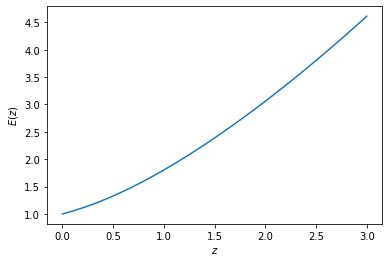

In [16]:
zz = np.linspace(0.,3.)
plt.plot(zz, E_of_z(zz))
plt.xlabel("$z$")
plt.ylabel("$E(z)$")

## Comoving distance

In [17]:
#Define the comoving distance
def drdz(zp):
    return (c_light/pars.H0)/E_of_z(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0.,zc)
rcom_vec = np.vectorize(rcom)
def rcom_tilde(zc):
    return rcom_vec(zc)/(c_light/pars.H0)

Text(0, 0.5, '$r(z)$')

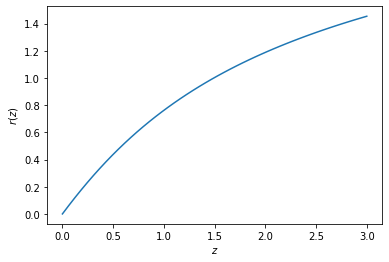

In [18]:
zz = np.linspace(0.,3.)

plt.plot(zz, rcom_tilde(zz))
plt.xlabel("$z$")
plt.ylabel("$r(z)$")

## Galaxy number density in bins

We take predefined equi-populated redshift bins from the Euclid IST:F specifications. In reality these numbers have to be computed given an $n(z)$  and a $p_{ph}(z_p | z)$ for the photometry.

In [19]:
z_bins = np.array([0.001, 0.418, 0.560, 0.678, 0.789, 0.900, 1.019, 1.155, 1.324, 1.576, 2.50])
z_max = z_bins[-1]
z_min = z_bins[0]
print("z_max survey: ", z_max, ",  z_min survey: ", z_min)

z_max survey:  2.5 ,  z_min survey:  0.001


In [20]:
len(z_bins)

11

In [21]:
def n_of_z(zz, z0=0.9/np.sqrt(2)):
    pref = zz/z0
    nn = pref**2 * np.exp(-pref**(3/2))
    return nn

In [22]:
n_norm = scipy.integrate.romberg(n_of_z,0.,z_max)
def norm_n_of_z(zz):
    return n_of_z(zz)/n_norm

In [23]:
def n_i(zz, ii):
    if ii==0 or ii >= 11:
        return None
    if zz <= z_bins[ii] and zz >= z_bins[ii-1]:
        return norm_n_of_z(zz)
    else:
        return 0

n_i_vec = np.vectorize(n_i)

## Window function

In [24]:
def window_integrand_2(zz, ii):
    w2n = n_i(zz, ii)/rcom_tilde(zz)
    return w2n

window_integrand_2_vec = np.vectorize(window_integrand_2)

In [37]:
def W_gamma(zz, ii):
    h0 = pars.H0
    Om = pars.omegam
    prefac = (3/2)*(h0/c_light)*Om*(1+zz)*rcom_tilde(zz)
    ni = lambda za : n_i(za, ii)
    int1 = scipy.integrate.romberg(ni, zz, z_max, divmax=20, tol=1e-4)
    w2 = lambda za : window_integrand_2(za, ii)
    int2 = rcom_tilde(zz) * scipy.integrate.romberg(w2, zz, z_max, divmax=15, tol=1e-4)
    total = prefac*(int1-int2)
    return total
W_gamma_vec = np.vectorize(W_gamma)

In [43]:
# long computation, uncomment if you have 5min or more to wait for the result
#zarr= np.linspace(0.01,3,100)
#color_list = cm.cool( np.linspace(0.,1.0, len(z_bins)+1 ) )
#color_iter=iter(color_list)
#for iii in np.arange(1,len(z_bins)):
#    c = next(color_iter)
#    Win = W_gamma_vec(zarr, iii)
#    plt.plot(zarr, Win, '-', c=c)

## Shear-Shear $C_{ij}$ function

In [123]:
def Cij_gg_integrand(zz, ell, i, j):
    h0 = pars.H0
    term1 = (c_light/h0)*(1/ (E_of_z(zz)*(rcom_vec(zz))**2))
    WW = W_gamma_vec(zz,i)*W_gamma_vec(zz,j)
    kell = (ell+0.5)/rcom_vec(zz)
    Pterm = PK.P(zz, kell)
    return term1*WW*Pterm

In [130]:
Cij_gg_integrand(0.5, 10, 2, 2)

2.0023231956028073e-13